In [1]:
# ============================================================
# TABLE 2 (Boston) + TABLE 3 (Auto MPG) — Boston-style tables
# Fixes Reviewer 2 issue: caption says max VIF and κ(XᵀX),
# so we COMPUTE and INCLUDE them in the table.
#
# Outputs:
#   - table2_boston.csv
#   - table3_auto.csv
#   - prints LaTeX for both (ready to paste into Article 1)
#
# Notes:
# - Uses K-fold CV on standardized X, centered y (train-mean),
#   reports CV_MSE and CV_R2 on RAW y scale (re-adding mean).
# - Diagnostics computed on standardized full design X (response-independent):
#     GMI(X), max VIF, κ(XᵀX)
# - Adds one stability metric: median(std(beta_j)) across CV folds.
# ============================================================

import numpy as np
import pandas as pd
import math
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# -----------------------------
# 0) Core geometry (GMI)
# -----------------------------
def gmi_from_gram(G, eps=1e-12):
    m = G.shape[0]
    sign, logdet = np.linalg.slogdet(G + eps*np.eye(m))
    if sign <= 0:
        return 1.0
    log_num = 0.5 * logdet
    log_den = 0.5 * np.sum(np.log(np.diag(G) + eps))
    psin = float(np.exp(log_num - log_den))
    return float(np.clip(1.0 - psin, 0.0, 1.0))

def compute_gmi(X):
    return gmi_from_gram(X.T @ X)

def kappa_xtx(X, eps=1e-12):
    # κ(XᵀX) via SVD on Gram, stable
    G = X.T @ X
    s = np.linalg.svd(G, compute_uv=False)
    if s.size == 0:
        return np.nan
    return float(s[0] / max(s[-1], eps))

# -----------------------------
# 1) max VIF (no statsmodels)
# -----------------------------
def max_vif(X, eps=1e-12):
    """
    VIF_j = 1/(1 - R^2_j) where R^2_j is from regressing x_j on X_{-j}.
    Computed via least squares; safe for rank-def via lstsq.
    """
    n, p = X.shape
    if p <= 1:
        return 1.0

    vifs = []
    for j in range(p):
        xj = X[:, j]
        Xo = np.delete(X, j, axis=1)

        # If other predictors empty, VIF is 1
        if Xo.shape[1] == 0:
            vifs.append(1.0)
            continue

        beta, *_ = np.linalg.lstsq(Xo, xj, rcond=None)
        xhat = Xo @ beta

        ss_res = float(np.sum((xj - xhat)**2))
        ss_tot = float(np.sum((xj - np.mean(xj))**2))
        if ss_tot < eps:
            # constant column => treat as "infinite multicollinearity"
            vifs.append(np.inf)
            continue

        r2 = 1.0 - ss_res / max(ss_tot, eps)
        r2 = float(np.clip(r2, 0.0, 1.0 - 1e-15))
        vifs.append(1.0 / max(1.0 - r2, eps))

    return float(np.max(vifs))

# -----------------------------
# 2) K-fold CV metrics + beta stability
# -----------------------------
def kfold_indices(n, k=5, seed=42):
    rng = np.random.default_rng(seed)
    idx = np.arange(n)
    rng.shuffle(idx)
    folds = np.array_split(idx, k)
    return folds

def cv_metrics_and_stability(X_raw, y_raw, k=5, seed=42):
    """
    - Standardize X using TRAIN fold stats
    - Center y using TRAIN mean
    - Fit OLS via lstsq on standardized X and centered y
    - Report MSE/R2 on RAW y (re-add mean_y)
    - Stability: median std of betas across folds
    """
    n = X_raw.shape[0]
    folds = kfold_indices(n, k=k, seed=seed)

    mses, r2s = [], []
    betas = []

    for i in range(k):
        val_idx = folds[i]
        tr_idx = np.concatenate([folds[j] for j in range(k) if j != i])

        Xtr, Xva = X_raw[tr_idx], X_raw[val_idx]
        ytr_raw, yva_raw = y_raw[tr_idx], y_raw[val_idx]

        scaler = StandardScaler()
        Xtr_s = scaler.fit_transform(Xtr)
        Xva_s = scaler.transform(Xva)

        y_mean = float(np.mean(ytr_raw))
        ytr = ytr_raw - y_mean
        yva = yva_raw - y_mean

        beta, *_ = np.linalg.lstsq(Xtr_s, ytr, rcond=None)
        betas.append(beta)

        yhat_va = Xva_s @ beta
        yhat_va_raw = yhat_va + y_mean

        mses.append(mean_squared_error(yva_raw, yhat_va_raw))
        r2s.append(r2_score(yva_raw, yhat_va_raw))

    B = np.vstack(betas)  # k x p
    beta_sd = np.std(B, axis=0, ddof=1) if B.shape[0] > 1 else np.zeros(B.shape[1])
    beta_sd_median = float(np.median(beta_sd)) if beta_sd.size else np.nan

    return float(np.mean(mses)), float(np.mean(r2s)), beta_sd_median

# -----------------------------
# 3) Load Boston + Auto (Option A or B)
# -----------------------------
ASSIGN_DIR = "/kaggle/input/assignment-1"
BOSTON_PATH = f"{ASSIGN_DIR}/DS for Predicting House Prices- Prblm 1.csv"
AUTO_PATH   = f"{ASSIGN_DIR}/DS for Predicting Car Mileage -Prblm 3.csv"

AUTO_MODE = "A"  # "A" (paper-friendly classic) or "B" (stress-test high-dim)

def _clean_cols(df):
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    return df

def load_boston_df(path=BOSTON_PATH):
    df = _clean_cols(pd.read_csv(path))
    if "medv" in df.columns and "Price" not in df.columns:
        df = df.rename(columns={"medv": "Price"})
    if "rm" in df.columns and "Area" not in df.columns:
        df = df.rename(columns={"rm": "Area"})
    # keep numeric only (Boston dataset should be numeric already)
    df = df.apply(pd.to_numeric, errors="coerce").dropna()
    if "Price" not in df.columns:
        raise ValueError(f"Boston: target column not found. Columns: {list(df.columns)}")
    return df

def load_auto_df_optionA(path=AUTO_PATH):
    df = _clean_cols(pd.read_csv(path))
    for c in ["car name", "car_name", "name"]:
        if c in df.columns:
            df = df.drop(columns=[c])
    df = df.replace("?", np.nan)

    required = ["mpg","cylinders","displacement","horsepower","weight","acceleration","model year","origin"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Auto Option A missing columns: {missing}. Columns: {list(df.columns)}")

    for c in required:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=required)
    return df

def load_regression_csv_strict(path, target_hint=None, drop_cols=("car name","car_name","name")):
    df = _clean_cols(pd.read_csv(path))
    for c in drop_cols:
        if c in df.columns:
            df = df.drop(columns=[c])

    candidates = []
    if target_hint:
        candidates += [target_hint, target_hint.lower(), target_hint.upper()]
    candidates += ["mpg","Price","price","medv","target","y"]
    target = next((c for c in candidates if c in df.columns), df.columns[-1])

    y = pd.to_numeric(df[target], errors="coerce")
    Xdf = df.drop(columns=[target])
    Xdf = pd.get_dummies(Xdf, drop_first=True)
    Xdf = Xdf.apply(pd.to_numeric, errors="coerce")

    data = pd.concat([Xdf, y.rename("target")], axis=1).dropna()
    X = data.drop(columns=["target"]).to_numpy(float)
    y = data["target"].to_numpy(float)
    return X, y, target, list(Xdf.columns)

def load_auto_df_optionB(path=AUTO_PATH):
    X, y, target, feat_names = load_regression_csv_strict(path, target_hint="mpg", drop_cols=("car name","car_name","name"))
    # rebuild a df so model-spec selection is easy
    df = pd.DataFrame(X, columns=feat_names)
    df[target] = y
    return df, target

def load_auto_for_tables(mode=AUTO_MODE):
    mode = str(mode).upper().strip()
    if mode == "A":
        df = load_auto_df_optionA()
        target = "mpg"
        return df, target
    if mode == "B":
        df, target = load_auto_df_optionB()
        return df, target
    raise ValueError("AUTO_MODE must be 'A' or 'B'.")

# -----------------------------
# 4) Build Boston-style “Table 2/3”
# -----------------------------
def pick_existing(df_cols, preferred):
    return [c for c in preferred if c in df_cols]

def build_table_for_dataset(df, target_col, dataset_label, model_specs, kfold=5, seed=42):
    rows = []
    for spec in model_specs:
        model_name = spec["model"]
        predictors = spec["predictors"]

        # guard: only keep columns that exist
        predictors = [c for c in predictors if c in df.columns]
        if len(predictors) == 0:
            continue

        X_raw = df[predictors].to_numpy(float)
        y_raw = df[target_col].to_numpy(float)

        # diagnostics computed on standardized FULL design (response-independent)
        Xs = StandardScaler().fit_transform(X_raw)
        gmi = compute_gmi(Xs)
        kappa = kappa_xtx(Xs)
        mvif = max_vif(Xs)

        # CV metrics + beta stability
        cv_mse, cv_r2, beta_sd_med = cv_metrics_and_stability(X_raw, y_raw, k=kfold, seed=seed)

        rows.append({
            "Dataset": dataset_label,
            "Model": model_name,
            "p": int(X_raw.shape[1]),
            "CV_MSE": float(cv_mse),
            "CV_R2": float(cv_r2),
            "GMI": float(gmi),
            "maxVIF": float(mvif),
            "kappa(XtX)": float(kappa),
            "medianSD(beta)": float(beta_sd_med),
        })

    out = pd.DataFrame(rows)
    # nice ordering
    out = out.sort_values(["p","CV_MSE"], ascending=[True, True]).reset_index(drop=True)
    return out

def latex_table(df, caption, label, floatfmt="%.3f"):
    # keep it compact and consistent
    cols = ["Model", "p", "CV_MSE", "CV_R2", "GMI", "maxVIF", "kappa(XtX)", "medianSD(beta)"]
    df2 = df[cols].copy()
    # format large VIFs
    df2["maxVIF"] = df2["maxVIF"].replace([np.inf], np.nan)

    tex = df2.to_latex(index=False, escape=False, float_format=floatfmt)
    tex = tex.replace("\\begin{table}", "\\begin{table}[t]")
    tex = tex.replace("\\begin{tabular}", "\\centering\n\\begin{tabular}")
    return f"""\\begin{{table}}[t]
\\caption{{{caption}}}
\\label{{{label}}}
{tex}
\\end{{table}}"""

# -----------------------------
# 5) Define model sets (Boston: p=1,4,>=6,full | Auto: p=1,3,>=6,full)
# -----------------------------
# Boston uses all available predictors except target; we pick “classic” names if present.
boston_df = load_boston_df()
boston_cols = list(boston_df.columns)
boston_target = "Price"

# Priority order (works for typical Boston schema; extra names are ignored if missing)
boston_priority = [
    "Area", "tax", "ptratio", "lstat",   # your existing 4
    "nox", "indus", "crim", "zn", "age", "dis", "rad", "black", "chas"
]
# model definitions
boston_p1 = pick_existing(boston_cols, ["Area"])
boston_p4 = pick_existing(boston_cols, ["Area","tax","ptratio","lstat"])
boston_p6 = pick_existing(boston_cols, boston_priority)[:6]
boston_full = [c for c in boston_cols if c != boston_target]

BOSTON_MODELS = [
    {"model": "Single-variable (Area → Price)", "predictors": boston_p1},
    {"model": "Multivariable (Area, tax, ptratio, lstat)", "predictors": boston_p4},
    {"model": "p≥6 model (Boston)", "predictors": boston_p6},
    {"model": "Full model (all predictors)", "predictors": boston_full},
]

# Auto
auto_df, auto_target = load_auto_for_tables(AUTO_MODE)
auto_cols = list(auto_df.columns)

if AUTO_MODE.upper() == "A":
    # Classic Auto MPG features
    auto_priority = ["weight","horsepower","displacement","cylinders","acceleration","model year","origin"]
    auto_p1 = pick_existing(auto_cols, ["weight"]) or pick_existing(auto_cols, ["horsepower"]) or [c for c in auto_cols if c != auto_target][:1]
    auto_p3 = pick_existing(auto_cols, ["displacement","horsepower","weight"]) or [c for c in auto_cols if c != auto_target][:3]
    auto_p6 = pick_existing(auto_cols, auto_priority)[:6]
    auto_full = [c for c in auto_cols if c != auto_target]  # should be 7
else:
    # Stress-test: choose 1,3,6,full from available columns
    non_target = [c for c in auto_cols if c != auto_target]
    auto_p1 = non_target[:1]
    auto_p3 = non_target[:3]
    auto_p6 = non_target[:6]
    auto_full = non_target

AUTO_MODELS = [
    {"model": "Single-variable model (Auto)", "predictors": auto_p1},
    {"model": "Engine-core model (Auto, p≈3)", "predictors": auto_p3},
    {"model": "p≥6 model (Auto)", "predictors": auto_p6},
    {"model": "Full model (Auto)", "predictors": auto_full},
]

# -----------------------------
# 6) Build Table 2 (Boston) + Table 3 (Auto)
# -----------------------------
df_table2 = build_table_for_dataset(
    boston_df, boston_target,
    dataset_label="Boston Housing",
    model_specs=BOSTON_MODELS,
    kfold=5, seed=42
)

df_table3 = build_table_for_dataset(
    auto_df, auto_target,
    dataset_label=f"Auto MPG (Option {AUTO_MODE})",
    model_specs=AUTO_MODELS,
    kfold=5, seed=42
)

print("\n=== TABLE 2 (Boston Housing) — Boston style, caption-consistent ===")
print(df_table2)

print("\n=== TABLE 3 (Auto MPG) — Same Boston style ===")
print(df_table3)

# Save CSVs (Kaggle: /kaggle/working/)
df_table2.to_csv("table2_boston.csv", index=False)
df_table3.to_csv("table3_auto.csv", index=False)
print("\nSaved: table2_boston.csv, table3_auto.csv")

# -----------------------------
# 7) Print LaTeX (paste into Article 1)
# -----------------------------
caption_boston = (
    "Boston Housing illustration (Table 2, revised). Predictive metrics are reported using K-fold "
    "cross-validation (CV) to avoid optimistic in-sample evaluation. Geometric diagnostics (GMI) are "
    "response-independent and are reported alongside standard multicollinearity diagnostics "
    "(maximum VIF and $\\kappa(X^{\\top}X)$). We additionally report a coefficient-stability summary "
    "(median SD of coefficients across CV folds)."
)

caption_auto = (
    "Auto MPG illustration (Table 3). We follow the same preprocessing and evaluation protocol as in "
    "the Boston Housing illustration. Predictive metrics are reported using K-fold CV, and geometric "
    "diagnostics (GMI) are reported alongside maximum VIF and $\\kappa(X^{\\top}X)$. The coefficient "
    "stability summary is the median SD of coefficients across CV folds."
)

latex_boston = latex_table(df_table2, caption_boston, label="tab:boston_gmi_vif_kappa", floatfmt="%.4f")
latex_auto   = latex_table(df_table3, caption_auto,   label="tab:auto_gmi_vif_kappa",   floatfmt="%.4f")

print("\n\n========== LaTeX: Table 2 (Boston) ==========\n")
print(latex_boston)

print("\n\n========== LaTeX: Table 3 (Auto MPG) ==========\n")
print(latex_auto)

print(f"\nAUTO_MODE used for Auto table: {AUTO_MODE}")



=== TABLE 2 (Boston Housing) — Boston style, caption-consistent ===
          Dataset                                      Model   p     CV_MSE  \
0  Boston Housing             Single-variable (Area → Price)   1  44.015565   
1  Boston Housing  Multivariable (Area, tax, ptratio, lstat)   4  28.019948   
2  Boston Housing                         p≥6 model (Boston)   6  28.199173   
3  Boston Housing                Full model (all predictors)  13  23.669648   

      CV_R2       GMI    maxVIF  kappa(XtX)  medianSD(beta)  
0  0.466685  0.000000  1.000000    1.000000        0.341623  
1  0.654722  0.433656  2.093985    7.847255        0.257174  
2  0.652895  0.789846  3.247388   17.224659        0.266056  
3  0.711853  0.988474  9.008554   96.471739        0.235180  

=== TABLE 3 (Auto MPG) — Same Boston style ===
               Dataset                          Model  p     CV_MSE     CV_R2  \
0  Auto MPG (Option A)   Single-variable model (Auto)  1  18.911998  0.681545   
1  Auto MPG (Op

In [2]:
# ============================================================
# TABLE 2 (Boston) + TABLE 3 (Auto MPG) — Boston-style tables
# Fixes Reviewer 2 issue: caption says max VIF and κ(XᵀX),
# so we COMPUTE and INCLUDE them in the table.
#
# Outputs:
#   - table2_boston.csv
#   - table3_auto.csv
#   - prints LaTeX for both (ready to paste into Article 1)
#
# Notes:
# - Uses K-fold CV on standardized X, centered y (train-mean),
#   reports CV_MSE and CV_R2 on RAW y scale (re-adding mean).
# - Diagnostics computed on standardized full design X (response-independent):
#     GMI(X), max VIF, κ(XᵀX)
# - Adds one stability metric: median(std(beta_j)) across CV folds.
# ============================================================

import numpy as np
import pandas as pd
import math
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# -----------------------------
# 0) Core geometry (GMI)
# -----------------------------
def gmi_from_gram(G, eps=1e-12):
    m = G.shape[0]
    sign, logdet = np.linalg.slogdet(G + eps*np.eye(m))
    if sign <= 0:
        return 1.0
    log_num = 0.5 * logdet
    log_den = 0.5 * np.sum(np.log(np.diag(G) + eps))
    psin = float(np.exp(log_num - log_den))
    return float(np.clip(1.0 - psin, 0.0, 1.0))

def compute_gmi(X):
    return gmi_from_gram(X.T @ X)

def kappa_xtx(X, eps=1e-12):
    # κ(XᵀX) via SVD on Gram, stable
    G = X.T @ X
    s = np.linalg.svd(G, compute_uv=False)
    if s.size == 0:
        return np.nan
    return float(s[0] / max(s[-1], eps))

# -----------------------------
# 1) max VIF (no statsmodels)
# -----------------------------
def max_vif(X, eps=1e-12):
    """
    VIF_j = 1/(1 - R^2_j) where R^2_j is from regressing x_j on X_{-j}.
    Computed via least squares; safe for rank-def via lstsq.
    """
    n, p = X.shape
    if p <= 1:
        return 1.0

    vifs = []
    for j in range(p):
        xj = X[:, j]
        Xo = np.delete(X, j, axis=1)

        # If other predictors empty, VIF is 1
        if Xo.shape[1] == 0:
            vifs.append(1.0)
            continue

        beta, *_ = np.linalg.lstsq(Xo, xj, rcond=None)
        xhat = Xo @ beta

        ss_res = float(np.sum((xj - xhat)**2))
        ss_tot = float(np.sum((xj - np.mean(xj))**2))
        if ss_tot < eps:
            # constant column => treat as "infinite multicollinearity"
            vifs.append(np.inf)
            continue

        r2 = 1.0 - ss_res / max(ss_tot, eps)
        r2 = float(np.clip(r2, 0.0, 1.0 - 1e-15))
        vifs.append(1.0 / max(1.0 - r2, eps))

    return float(np.max(vifs))

# -----------------------------
# 2) K-fold CV metrics + beta stability
# -----------------------------
def kfold_indices(n, k=5, seed=42):
    rng = np.random.default_rng(seed)
    idx = np.arange(n)
    rng.shuffle(idx)
    folds = np.array_split(idx, k)
    return folds

def cv_metrics_and_stability(X_raw, y_raw, k=5, seed=42):
    """
    - Standardize X using TRAIN fold stats
    - Center y using TRAIN mean
    - Fit OLS via lstsq on standardized X and centered y
    - Report MSE/R2 on RAW y (re-add mean_y)
    - Stability: median std of betas across folds
    """
    n = X_raw.shape[0]
    folds = kfold_indices(n, k=k, seed=seed)

    mses, r2s = [], []
    betas = []

    for i in range(k):
        val_idx = folds[i]
        tr_idx = np.concatenate([folds[j] for j in range(k) if j != i])

        Xtr, Xva = X_raw[tr_idx], X_raw[val_idx]
        ytr_raw, yva_raw = y_raw[tr_idx], y_raw[val_idx]

        scaler = StandardScaler()
        Xtr_s = scaler.fit_transform(Xtr)
        Xva_s = scaler.transform(Xva)

        y_mean = float(np.mean(ytr_raw))
        ytr = ytr_raw - y_mean
        yva = yva_raw - y_mean

        beta, *_ = np.linalg.lstsq(Xtr_s, ytr, rcond=None)
        betas.append(beta)

        yhat_va = Xva_s @ beta
        yhat_va_raw = yhat_va + y_mean

        mses.append(mean_squared_error(yva_raw, yhat_va_raw))
        r2s.append(r2_score(yva_raw, yhat_va_raw))

    B = np.vstack(betas)  # k x p
    beta_sd = np.std(B, axis=0, ddof=1) if B.shape[0] > 1 else np.zeros(B.shape[1])
    beta_sd_median = float(np.median(beta_sd)) if beta_sd.size else np.nan

    return float(np.mean(mses)), float(np.mean(r2s)), beta_sd_median

# -----------------------------
# 3) Load Boston + Auto (Option A or B)
# -----------------------------
ASSIGN_DIR = "/kaggle/input/assignment-1"
BOSTON_PATH = f"{ASSIGN_DIR}/DS for Predicting House Prices- Prblm 1.csv"
AUTO_PATH   = f"{ASSIGN_DIR}/DS for Predicting Car Mileage -Prblm 3.csv"

AUTO_MODE = "A"  # "A" (paper-friendly classic) or "B" (stress-test high-dim)

def _clean_cols(df):
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    return df

def load_boston_df(path=BOSTON_PATH):
    df = _clean_cols(pd.read_csv(path))
    if "medv" in df.columns and "Price" not in df.columns:
        df = df.rename(columns={"medv": "Price"})
    if "rm" in df.columns and "Area" not in df.columns:
        df = df.rename(columns={"rm": "Area"})
    # keep numeric only (Boston dataset should be numeric already)
    df = df.apply(pd.to_numeric, errors="coerce").dropna()
    if "Price" not in df.columns:
        raise ValueError(f"Boston: target column not found. Columns: {list(df.columns)}")
    return df

def load_auto_df_optionA(path=AUTO_PATH):
    df = _clean_cols(pd.read_csv(path))
    for c in ["car name", "car_name", "name"]:
        if c in df.columns:
            df = df.drop(columns=[c])
    df = df.replace("?", np.nan)

    required = ["mpg","cylinders","displacement","horsepower","weight","acceleration","model year","origin"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Auto Option A missing columns: {missing}. Columns: {list(df.columns)}")

    for c in required:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=required)
    return df

def load_regression_csv_strict(path, target_hint=None, drop_cols=("car name","car_name","name")):
    df = _clean_cols(pd.read_csv(path))
    for c in drop_cols:
        if c in df.columns:
            df = df.drop(columns=[c])

    candidates = []
    if target_hint:
        candidates += [target_hint, target_hint.lower(), target_hint.upper()]
    candidates += ["mpg","Price","price","medv","target","y"]
    target = next((c for c in candidates if c in df.columns), df.columns[-1])

    y = pd.to_numeric(df[target], errors="coerce")
    Xdf = df.drop(columns=[target])
    Xdf = pd.get_dummies(Xdf, drop_first=True)
    Xdf = Xdf.apply(pd.to_numeric, errors="coerce")

    data = pd.concat([Xdf, y.rename("target")], axis=1).dropna()
    X = data.drop(columns=["target"]).to_numpy(float)
    y = data["target"].to_numpy(float)
    return X, y, target, list(Xdf.columns)

def load_auto_df_optionB(path=AUTO_PATH):
    X, y, target, feat_names = load_regression_csv_strict(path, target_hint="mpg", drop_cols=("car name","car_name","name"))
    # rebuild a df so model-spec selection is easy
    df = pd.DataFrame(X, columns=feat_names)
    df[target] = y
    return df, target

def load_auto_for_tables(mode=AUTO_MODE):
    mode = str(mode).upper().strip()
    if mode == "A":
        df = load_auto_df_optionA()
        target = "mpg"
        return df, target
    if mode == "B":
        df, target = load_auto_df_optionB()
        return df, target
    raise ValueError("AUTO_MODE must be 'A' or 'B'.")

# -----------------------------
# 4) Build Boston-style “Table 2/3”
# -----------------------------
def pick_existing(df_cols, preferred):
    return [c for c in preferred if c in df_cols]

def build_table_for_dataset(df, target_col, dataset_label, model_specs, kfold=5, seed=42):
    rows = []
    for spec in model_specs:
        model_name = spec["model"]
        predictors = spec["predictors"]

        # guard: only keep columns that exist
        predictors = [c for c in predictors if c in df.columns]
        if len(predictors) == 0:
            continue

        X_raw = df[predictors].to_numpy(float)
        y_raw = df[target_col].to_numpy(float)

        # diagnostics computed on standardized FULL design (response-independent)
        Xs = StandardScaler().fit_transform(X_raw)
        gmi = compute_gmi(Xs)
        kappa = kappa_xtx(Xs)
        mvif = max_vif(Xs)

        # CV metrics + beta stability
        cv_mse, cv_r2, beta_sd_med = cv_metrics_and_stability(X_raw, y_raw, k=kfold, seed=seed)

        rows.append({
            "Dataset": dataset_label,
            "Model": model_name,
            "p": int(X_raw.shape[1]),
            "CV_MSE": float(cv_mse),
            "CV_R2": float(cv_r2),
            "GMI": float(gmi),
            "maxVIF": float(mvif),
            "kappa(XtX)": float(kappa),
            "medianSD(beta)": float(beta_sd_med),
        })

    out = pd.DataFrame(rows)
    # nice ordering
    out = out.sort_values(["p","CV_MSE"], ascending=[True, True]).reset_index(drop=True)
    return out

def latex_table(df, caption, label, floatfmt="%.3f"):
    # keep it compact and consistent
    cols = ["Model", "p", "CV_MSE", "CV_R2", "GMI", "maxVIF", "kappa(XtX)", "medianSD(beta)"]
    df2 = df[cols].copy()
    # format large VIFs
    df2["maxVIF"] = df2["maxVIF"].replace([np.inf], np.nan)

    tex = df2.to_latex(index=False, escape=False, float_format=floatfmt)
    tex = tex.replace("\\begin{table}", "\\begin{table}[t]")
    tex = tex.replace("\\begin{tabular}", "\\centering\n\\begin{tabular}")
    return f"""\\begin{{table}}[t]
\\caption{{{caption}}}
\\label{{{label}}}
{tex}
\\end{{table}}"""

# -----------------------------
# 5) Define model sets (Boston: p=1,4,>=6,full | Auto: p=1,3,>=6,full)
# -----------------------------
# Boston uses all available predictors except target; we pick “classic” names if present.
boston_df = load_boston_df()
boston_cols = list(boston_df.columns)
boston_target = "Price"

# Priority order (works for typical Boston schema; extra names are ignored if missing)
boston_priority = [
    "Area", "tax", "ptratio", "lstat",   # your existing 4
    "nox", "indus", "crim", "zn", "age", "dis", "rad", "black", "chas"
]
# model definitions
boston_p1 = pick_existing(boston_cols, ["Area"])
boston_p4 = pick_existing(boston_cols, ["Area","tax","ptratio","lstat"])
boston_p6 = pick_existing(boston_cols, boston_priority)[:6]
boston_full = [c for c in boston_cols if c != boston_target]

BOSTON_MODELS = [
    {"model": "Single-variable (Area → Price)", "predictors": boston_p1},
    {"model": "Multivariable (Area, tax, ptratio, lstat)", "predictors": boston_p4},
    {"model": "p≥6 model (Boston)", "predictors": boston_p6},
    {"model": "Full model (all predictors)", "predictors": boston_full},
]

# Auto
auto_df, auto_target = load_auto_for_tables(AUTO_MODE)
auto_cols = list(auto_df.columns)

if AUTO_MODE.upper() == "A":
    # Classic Auto MPG features
    auto_priority = ["weight","horsepower","displacement","cylinders","acceleration","model year","origin"]
    auto_p1 = pick_existing(auto_cols, ["weight"]) or pick_existing(auto_cols, ["horsepower"]) or [c for c in auto_cols if c != auto_target][:1]
    auto_p3 = pick_existing(auto_cols, ["displacement","horsepower","weight"]) or [c for c in auto_cols if c != auto_target][:3]
    auto_p6 = pick_existing(auto_cols, auto_priority)[:6]
    auto_full = [c for c in auto_cols if c != auto_target]  # should be 7
else:
    # Stress-test: choose 1,3,6,full from available columns
    non_target = [c for c in auto_cols if c != auto_target]
    auto_p1 = non_target[:1]
    auto_p3 = non_target[:3]
    auto_p6 = non_target[:6]
    auto_full = non_target

AUTO_MODELS = [
    {"model": "Single-variable model (Auto)", "predictors": auto_p1},
    {"model": "Engine-core model (Auto, p≈3)", "predictors": auto_p3},
    {"model": "p≥6 model (Auto)", "predictors": auto_p6},
    {"model": "Full model (Auto)", "predictors": auto_full},
]

# -----------------------------
# 6) Build Table 2 (Boston) + Table 3 (Auto)
# -----------------------------
df_table2 = build_table_for_dataset(
    boston_df, boston_target,
    dataset_label="Boston Housing",
    model_specs=BOSTON_MODELS,
    kfold=5, seed=42
)

df_table3 = build_table_for_dataset(
    auto_df, auto_target,
    dataset_label=f"Auto MPG (Option {AUTO_MODE})",
    model_specs=AUTO_MODELS,
    kfold=5, seed=42
)

print("\n=== TABLE 2 (Boston Housing) — Boston style, caption-consistent ===")
print(df_table2)

print("\n=== TABLE 3 (Auto MPG) — Same Boston style ===")
print(df_table3)

# Save CSVs (Kaggle: /kaggle/working/)
df_table2.to_csv("table2_boston.csv", index=False)
df_table3.to_csv("table3_auto.csv", index=False)
print("\nSaved: table2_boston.csv, table3_auto.csv")

# -----------------------------
# 7) Print LaTeX (paste into Article 1)
# -----------------------------
caption_boston = (
    "Boston Housing illustration (Table 2, revised). Predictive metrics are reported using K-fold "
    "cross-validation (CV) to avoid optimistic in-sample evaluation. Geometric diagnostics (GMI) are "
    "response-independent and are reported alongside standard multicollinearity diagnostics "
    "(maximum VIF and $\\kappa(X^{\\top}X)$). We additionally report a coefficient-stability summary "
    "(median SD of coefficients across CV folds)."
)

caption_auto = (
    "Auto MPG illustration (Table 3). We follow the same preprocessing and evaluation protocol as in "
    "the Boston Housing illustration. Predictive metrics are reported using K-fold CV, and geometric "
    "diagnostics (GMI) are reported alongside maximum VIF and $\\kappa(X^{\\top}X)$. The coefficient "
    "stability summary is the median SD of coefficients across CV folds."
)

latex_boston = latex_table(df_table2, caption_boston, label="tab:boston_gmi_vif_kappa", floatfmt="%.4f")
latex_auto   = latex_table(df_table3, caption_auto,   label="tab:auto_gmi_vif_kappa",   floatfmt="%.4f")

print("\n\n========== LaTeX: Table 2 (Boston) ==========\n")
print(latex_boston)

print("\n\n========== LaTeX: Table 3 (Auto MPG) ==========\n")
print(latex_auto)

print(f"\nAUTO_MODE used for Auto table: {AUTO_MODE}")



=== TABLE 2 (Boston Housing) — Boston style, caption-consistent ===
          Dataset                                      Model   p     CV_MSE  \
0  Boston Housing             Single-variable (Area → Price)   1  44.015565   
1  Boston Housing  Multivariable (Area, tax, ptratio, lstat)   4  28.019948   
2  Boston Housing                         p≥6 model (Boston)   6  28.199173   
3  Boston Housing                Full model (all predictors)  13  23.669648   

      CV_R2       GMI    maxVIF  kappa(XtX)  medianSD(beta)  
0  0.466685  0.000000  1.000000    1.000000        0.341623  
1  0.654722  0.433656  2.093985    7.847255        0.257174  
2  0.652895  0.789846  3.247388   17.224659        0.266056  
3  0.711853  0.988474  9.008554   96.471739        0.235180  

=== TABLE 3 (Auto MPG) — Same Boston style ===
               Dataset                          Model  p     CV_MSE     CV_R2  \
0  Auto MPG (Option A)   Single-variable model (Auto)  1  18.911998  0.681545   
1  Auto MPG (Op

In [3]:
# ============================================================
# TABLE 2 (Boston) + TABLE 3 (Auto MPG) — Boston-style tables
# Reviewer-2 fix: caption promises max VIF + κ(XᵀX),
# so we compute and include them.
#
# Outputs (Kaggle: /kaggle/working/):
#   - table2_boston.csv
#   - table3_auto.csv
#   - prints LaTeX for both tables
#
# Auto switch:
#   AUTO_MODE="A" => classic 7-feature Auto MPG (recommended for main paper)
#   AUTO_MODE="B" => high-dim one-hot Auto MPG (stress-test)
# ============================================================

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# -----------------------------
# USER SWITCH
# -----------------------------
AUTO_MODE = "A"  # "A" or "B"

ASSIGN_DIR = "/kaggle/input/assignment-1"
BOSTON_PATH = f"{ASSIGN_DIR}/DS for Predicting House Prices- Prblm 1.csv"
AUTO_PATH   = f"{ASSIGN_DIR}/DS for Predicting Car Mileage -Prblm 3.csv"

# -----------------------------
# 0) Helpers: clean + alias picking
# -----------------------------
def _clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    return df

def pick_one(df_cols, aliases):
    """Return first alias that exists (case-insensitive match too)."""
    cols = list(df_cols)
    lower_map = {c.lower(): c for c in cols}
    for a in aliases:
        if a in cols:
            return a
        if a.lower() in lower_map:
            return lower_map[a.lower()]
    return None

def pick_many(df_cols, alias_groups, take=None):
    """alias_groups = list of lists. Pick first existing col from each group."""
    chosen = []
    for group in alias_groups:
        c = pick_one(df_cols, group)
        if c is not None and c not in chosen:
            chosen.append(c)
    if take is not None:
        chosen = chosen[:take]
    return chosen

# -----------------------------
# 1) GMI + κ(XᵀX)
# -----------------------------
def gmi_from_gram(G, eps=1e-12):
    m = G.shape[0]
    sign, logdet = np.linalg.slogdet(G + eps*np.eye(m))
    if sign <= 0:
        return 1.0
    log_num = 0.5 * logdet
    log_den = 0.5 * np.sum(np.log(np.diag(G) + eps))
    psin = float(np.exp(log_num - log_den))
    return float(np.clip(1.0 - psin, 0.0, 1.0))

def compute_gmi(X):
    return gmi_from_gram(X.T @ X)

def kappa_xtx(X, eps=1e-12):
    G = X.T @ X
    s = np.linalg.svd(G, compute_uv=False)
    if s.size == 0:
        return np.nan
    return float(s[0] / max(s[-1], eps))

# -----------------------------
# 2) max VIF (no statsmodels)
# -----------------------------
def max_vif(X, eps=1e-12):
    n, p = X.shape
    if p <= 1:
        return 1.0

    vifs = []
    for j in range(p):
        xj = X[:, j]
        Xo = np.delete(X, j, axis=1)
        if Xo.shape[1] == 0:
            vifs.append(1.0)
            continue

        beta, *_ = np.linalg.lstsq(Xo, xj, rcond=None)
        xhat = Xo @ beta

        ss_res = float(np.sum((xj - xhat)**2))
        ss_tot = float(np.sum((xj - np.mean(xj))**2))
        if ss_tot < eps:
            vifs.append(np.inf)
            continue

        r2 = 1.0 - ss_res / max(ss_tot, eps)
        r2 = float(np.clip(r2, 0.0, 1.0 - 1e-15))
        vifs.append(1.0 / max(1.0 - r2, eps))

    return float(np.max(vifs))

# -----------------------------
# 3) K-fold CV metrics + beta stability
# -----------------------------
def kfold_indices(n, k=5, seed=42):
    rng = np.random.default_rng(seed)
    idx = np.arange(n)
    rng.shuffle(idx)
    return np.array_split(idx, k)

def cv_metrics_and_stability(X_raw, y_raw, k=5, seed=42):
    n = X_raw.shape[0]
    folds = kfold_indices(n, k=k, seed=seed)

    mses, r2s, betas = [], [], []

    for i in range(k):
        val_idx = folds[i]
        tr_idx = np.concatenate([folds[j] for j in range(k) if j != i])

        Xtr, Xva = X_raw[tr_idx], X_raw[val_idx]
        ytr_raw, yva_raw = y_raw[tr_idx], y_raw[val_idx]

        scaler = StandardScaler()
        Xtr_s = scaler.fit_transform(Xtr)
        Xva_s = scaler.transform(Xva)

        y_mean = float(np.mean(ytr_raw))
        ytr = ytr_raw - y_mean

        beta, *_ = np.linalg.lstsq(Xtr_s, ytr, rcond=None)
        betas.append(beta)

        yhat_va_raw = (Xva_s @ beta) + y_mean
        mses.append(mean_squared_error(yva_raw, yhat_va_raw))
        r2s.append(r2_score(yva_raw, yhat_va_raw))

    B = np.vstack(betas)  # k x p
    beta_sd = np.std(B, axis=0, ddof=1) if B.shape[0] > 1 else np.zeros(B.shape[1])
    beta_sd_median = float(np.median(beta_sd)) if beta_sd.size else np.nan

    return float(np.mean(mses)), float(np.mean(r2s)), beta_sd_median

# -----------------------------
# 4) Load Boston + Auto
# -----------------------------
def load_boston_df(path=BOSTON_PATH):
    df = _clean_cols(pd.read_csv(path))
    df = df.apply(pd.to_numeric, errors="coerce").dropna()
    return df

def load_auto_df_optionA(path=AUTO_PATH):
    df = _clean_cols(pd.read_csv(path))
    for c in ["car name", "car_name", "name"]:
        if c in df.columns:
            df = df.drop(columns=[c])
    df = df.replace("?", np.nan)

    required = ["mpg","cylinders","displacement","horsepower","weight","acceleration","model year","origin"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Auto Option A missing columns: {missing}. Columns: {list(df.columns)}")

    for c in required:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=required)
    return df, "mpg"

def load_regression_csv_strict(path, target_hint=None, drop_cols=("car name","car_name","name")):
    df = _clean_cols(pd.read_csv(path))
    for c in drop_cols:
        if c in df.columns:
            df = df.drop(columns=[c])

    candidates = []
    if target_hint:
        candidates += [target_hint, target_hint.lower(), target_hint.upper()]
    candidates += ["mpg","Price","price","medv","target","y"]
    target = next((c for c in candidates if c in df.columns), df.columns[-1])

    y = pd.to_numeric(df[target], errors="coerce")
    Xdf = df.drop(columns=[target])
    Xdf = pd.get_dummies(Xdf, drop_first=True)
    Xdf = Xdf.apply(pd.to_numeric, errors="coerce")

    data = pd.concat([Xdf, y.rename("target")], axis=1).dropna()
    X = data.drop(columns=["target"]).to_numpy(float)
    y = data["target"].to_numpy(float)
    return X, y, target, list(Xdf.columns)

def load_auto_df_optionB(path=AUTO_PATH):
    X, y, target, feat_names = load_regression_csv_strict(path, target_hint="mpg", drop_cols=("car name","car_name","name"))
    df = pd.DataFrame(X, columns=feat_names)
    df[target] = y
    return df, target

def load_auto_for_tables(mode=AUTO_MODE):
    mode = str(mode).upper().strip()
    if mode == "A":
        return load_auto_df_optionA()
    if mode == "B":
        return load_auto_df_optionB()
    raise ValueError("AUTO_MODE must be 'A' or 'B'.")

# -----------------------------
# 5) Build Boston-style table
# -----------------------------
def build_table_for_dataset(df, target_col, dataset_label, model_specs, kfold=5, seed=42):
    rows = []
    for spec in model_specs:
        model_name = spec["model"]
        predictors = [c for c in spec["predictors"] if c in df.columns]

        if len(predictors) == 0:
            continue

        X_raw = df[predictors].to_numpy(float)
        y_raw = df[target_col].to_numpy(float)

        # diagnostics on standardized full design
        Xs = StandardScaler().fit_transform(X_raw)
        gmi = compute_gmi(Xs)
        kappa = kappa_xtx(Xs)
        mvif = max_vif(Xs)

        # CV metrics + stability
        cv_mse, cv_r2, beta_sd_med = cv_metrics_and_stability(X_raw, y_raw, k=kfold, seed=seed)

        rows.append({
            "Dataset": dataset_label,
            "Model": model_name,
            "p": int(X_raw.shape[1]),
            "CV_MSE": float(cv_mse),
            "CV_R2": float(cv_r2),
            "GMI": float(gmi),
            "maxVIF": float(mvif),
            "kappa(XtX)": float(kappa),
            "medianSD(beta)": float(beta_sd_med),
        })

    out = pd.DataFrame(rows).sort_values(["p","CV_MSE"], ascending=[True, True]).reset_index(drop=True)
    return out

def latex_table(df, caption, label, floatfmt="%.4f"):
    cols = ["Model", "p", "CV_MSE", "CV_R2", "GMI", "maxVIF", "kappa(XtX)", "medianSD(beta)"]
    df2 = df[cols].copy()
    df2["maxVIF"] = df2["maxVIF"].replace([np.inf], np.nan)

    tex = df2.to_latex(index=False, escape=False, float_format=floatfmt)
    tex = tex.replace("\\begin{table}", "\\begin{table}[t]")
    tex = tex.replace("\\begin{tabular}", "\\centering\n\\begin{tabular}")
    return f"""\\begin{{table}}[t]
\\caption{{{caption}}}
\\label{{{label}}}
{tex}
\\end{{table}}"""

# ============================================================
# 6) LOCKED Boston model specs (p=1, p=4, p≥6, full)
# ============================================================
boston_df = load_boston_df()
cols = list(boston_df.columns)

# target alias (robust)
boston_target = pick_one(cols, ["Price", "medv", "MEDV"])
if boston_target is None:
    boston_target = cols[-1]  # last resort

# predictor aliases (robust)
AREA_COL = pick_one(cols, ["Area", "rm", "RM"])
LSTAT_COL = pick_one(cols, ["lstat", "LSTAT"])
PTRATIO_COL = pick_one(cols, ["ptratio", "PTRATIO"])
TAX_COL = pick_one(cols, ["tax", "TAX"])
NOX_COL = pick_one(cols, ["nox", "NOX"])
INDUS_COL = pick_one(cols, ["indus", "INDUS"])
CRIM_COL = pick_one(cols, ["crim", "CRIM"])
DIS_COL = pick_one(cols, ["dis", "DIS"])

# p=1
boston_p1 = [c for c in [AREA_COL] if c is not None]

# p=4 (your existing Boston narrative)
boston_p4 = [c for c in [AREA_COL, TAX_COL, PTRATIO_COL, LSTAT_COL] if c is not None]

# p≥6 (LOCKED, ordered, narrative-friendly)
# primary 6: Area/RM, LSTAT, PTRATIO, TAX, NOX, INDUS
# extras if available: CRIM, DIS (kept only if you decide to expand to 7–8 later)
boston_p6_locked = [c for c in [AREA_COL, LSTAT_COL, PTRATIO_COL, TAX_COL, NOX_COL, INDUS_COL] if c is not None]
# if any are missing, fill from remaining sensible cols (excluding target)
if len(boston_p6_locked) < 6:
    fallback_pool = [c for c in [CRIM_COL, DIS_COL] if c is not None]
    # then add any other non-target columns as last resort
    fallback_pool += [c for c in cols if c not in fallback_pool and c != boston_target]
    for c in fallback_pool:
        if c not in boston_p6_locked and c != boston_target:
            boston_p6_locked.append(c)
        if len(boston_p6_locked) >= 6:
            break

# full
boston_full = [c for c in cols if c != boston_target]

BOSTON_MODELS = [
    {"model": f"p=1 ({boston_p1[0]} → {boston_target})" if boston_p1 else "p=1 (single predictor)", "predictors": boston_p1},
    {"model": "p=4 (Area/RM, TAX, PTRATIO, LSTAT)", "predictors": boston_p4},
    {"model": "p≥6 (RM/Area, LSTAT, PTRATIO, TAX, NOX, INDUS)", "predictors": boston_p6_locked[:6]},
    {"model": "Full model (all predictors)", "predictors": boston_full},
]

# ============================================================
# 7) Auto model specs (robust for A or B)
# ============================================================
auto_df, auto_target = load_auto_for_tables(AUTO_MODE)
auto_cols = list(auto_df.columns)
non_target = [c for c in auto_cols if c != auto_target]

if AUTO_MODE.upper() == "A":
    # Classic Auto MPG: weight/horsepower/displacement/etc.
    auto_priority = ["weight","horsepower","displacement","cylinders","acceleration","model year","origin"]
    auto_p1 = pick_many(auto_cols, [["weight"],["horsepower"]], take=1) or non_target[:1]
    auto_p3 = pick_many(auto_cols, [["displacement"],["horsepower"],["weight"]], take=3) or non_target[:3]
    auto_p6 = pick_many(auto_cols, [[c] for c in auto_priority], take=6) or non_target[:6]
    auto_full = non_target
else:
    # Stress-test: arbitrary 1/3/6/full
    auto_p1 = non_target[:1]
    auto_p3 = non_target[:3]
    auto_p6 = non_target[:6]
    auto_full = non_target

AUTO_MODELS = [
    {"model": "p=1 model (Auto)", "predictors": auto_p1},
    {"model": "p=3 engine-core (Auto)", "predictors": auto_p3},
    {"model": "p≥6 model (Auto)", "predictors": auto_p6},
    {"model": "Full model (Auto)", "predictors": auto_full},
]

# ============================================================
# 8) Build tables + export
# ============================================================
df_table2 = build_table_for_dataset(
    boston_df, boston_target,
    dataset_label="Boston Housing",
    model_specs=BOSTON_MODELS,
    kfold=5, seed=42
)

df_table3 = build_table_for_dataset(
    auto_df, auto_target,
    dataset_label=f"Auto MPG (Option {AUTO_MODE})",
    model_specs=AUTO_MODELS,
    kfold=5, seed=42
)

print("\n=== TABLE 2 (Boston Housing) — FIXED (includes maxVIF + κ) ===")
print(df_table2)

print("\n=== TABLE 3 (Auto MPG) — SAME STYLE ===")
print(df_table3)

df_table2.to_csv("table2_boston.csv", index=False)
df_table3.to_csv("table3_auto.csv", index=False)
print("\nSaved: table2_boston.csv, table3_auto.csv")

# ============================================================
# 9) LaTeX for Article 1
# ============================================================
caption_boston = (
    "Boston Housing illustration (Table 2, revised). Predictive metrics are reported using K-fold "
    "cross-validation (CV). Geometric diagnostics (GMI) are response-independent and are reported "
    "alongside standard multicollinearity diagnostics (maximum VIF and $\\kappa(X^{\\top}X)$). "
    "We additionally report a coefficient-stability summary (median SD of coefficients across CV folds)."
)

caption_auto = (
    "Auto MPG illustration (Table 3). We follow the same preprocessing and evaluation protocol as in "
    "the Boston Housing illustration. Predictive metrics are reported using K-fold CV, and geometric "
    "diagnostics (GMI) are reported alongside maximum VIF and $\\kappa(X^{\\top}X)$. The coefficient "
    "stability summary is the median SD of coefficients across CV folds."
)

latex_boston = latex_table(df_table2, caption_boston, label="tab:boston_gmi_vif_kappa", floatfmt="%.4f")
latex_auto   = latex_table(df_table3, caption_auto,   label="tab:auto_gmi_vif_kappa",   floatfmt="%.4f")

print("\n\n========== LaTeX: Table 2 (Boston) ==========\n")
print(latex_boston)

print("\n\n========== LaTeX: Table 3 (Auto MPG) ==========\n")
print(latex_auto)

print(f"\nAUTO_MODE used for Auto table: {AUTO_MODE}")



=== TABLE 2 (Boston Housing) — FIXED (includes maxVIF + κ) ===
          Dataset                                           Model   p  \
0  Boston Housing                                 p=1 (rm → medv)   1   
1  Boston Housing              p=4 (Area/RM, TAX, PTRATIO, LSTAT)   4   
2  Boston Housing  p≥6 (RM/Area, LSTAT, PTRATIO, TAX, NOX, INDUS)   6   
3  Boston Housing                     Full model (all predictors)  13   

      CV_MSE     CV_R2       GMI    maxVIF  kappa(XtX)  medianSD(beta)  
0  44.015565  0.466685  0.000000  1.000000    1.000000        0.341623  
1  28.019948  0.654722  0.433656  2.093985    7.847255        0.257174  
2  28.199173  0.652895  0.789846  3.247388   17.224659        0.266056  
3  23.669648  0.711853  0.988474  9.008554   96.471739        0.235180  

=== TABLE 3 (Auto MPG) — SAME STYLE ===
               Dataset                   Model  p     CV_MSE     CV_R2  \
0  Auto MPG (Option A)        p=1 model (Auto)  1  18.911998  0.681545   
1  Auto MPG (Opt

In [4]:
# ============================================================
# TABLE 2 (Boston) + TABLE 3 (Auto MPG) — Boston-style tables
# Reviewer-2 fix: caption promises max VIF + κ(XᵀX),
# so we compute and include them.
#
# Outputs (Kaggle: /kaggle/working/):
#   - table2_boston.csv
#   - table3_auto.csv
#   - prints LaTeX for both tables
#
# Auto switch:
#   AUTO_MODE="A" => classic 7-feature Auto MPG (recommended for main paper)
#   AUTO_MODE="B" => high-dim one-hot Auto MPG (stress-test)
# ============================================================

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# -----------------------------
# USER SWITCH
# -----------------------------
AUTO_MODE = "A"  # "A" or "B"

ASSIGN_DIR = "/kaggle/input/assignment-1"
BOSTON_PATH = f"{ASSIGN_DIR}/DS for Predicting House Prices- Prblm 1.csv"
AUTO_PATH   = f"{ASSIGN_DIR}/DS for Predicting Car Mileage -Prblm 3.csv"

# -----------------------------
# 0) Helpers: clean + alias picking
# -----------------------------
def _clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    return df

def pick_one(df_cols, aliases):
    """Return first alias that exists (case-insensitive match too)."""
    cols = list(df_cols)
    lower_map = {c.lower(): c for c in cols}
    for a in aliases:
        if a in cols:
            return a
        if a.lower() in lower_map:
            return lower_map[a.lower()]
    return None

def pick_many(df_cols, alias_groups, take=None):
    """alias_groups = list of lists. Pick first existing col from each group."""
    chosen = []
    for group in alias_groups:
        c = pick_one(df_cols, group)
        if c is not None and c not in chosen:
            chosen.append(c)
    if take is not None:
        chosen = chosen[:take]
    return chosen

# -----------------------------
# 1) GMI + κ(XᵀX)
# -----------------------------
def gmi_from_gram(G, eps=1e-12):
    m = G.shape[0]
    sign, logdet = np.linalg.slogdet(G + eps*np.eye(m))
    if sign <= 0:
        return 1.0
    log_num = 0.5 * logdet
    log_den = 0.5 * np.sum(np.log(np.diag(G) + eps))
    psin = float(np.exp(log_num - log_den))
    return float(np.clip(1.0 - psin, 0.0, 1.0))

def compute_gmi(X):
    return gmi_from_gram(X.T @ X)

def kappa_xtx(X, eps=1e-12):
    G = X.T @ X
    s = np.linalg.svd(G, compute_uv=False)
    if s.size == 0:
        return np.nan
    return float(s[0] / max(s[-1], eps))

# -----------------------------
# 2) max VIF (no statsmodels)
# -----------------------------
def max_vif(X, eps=1e-12):
    n, p = X.shape
    if p <= 1:
        return 1.0

    vifs = []
    for j in range(p):
        xj = X[:, j]
        Xo = np.delete(X, j, axis=1)
        if Xo.shape[1] == 0:
            vifs.append(1.0)
            continue

        beta, *_ = np.linalg.lstsq(Xo, xj, rcond=None)
        xhat = Xo @ beta

        ss_res = float(np.sum((xj - xhat)**2))
        ss_tot = float(np.sum((xj - np.mean(xj))**2))
        if ss_tot < eps:
            vifs.append(np.inf)
            continue

        r2 = 1.0 - ss_res / max(ss_tot, eps)
        r2 = float(np.clip(r2, 0.0, 1.0 - 1e-15))
        vifs.append(1.0 / max(1.0 - r2, eps))

    return float(np.max(vifs))

# -----------------------------
# 3) K-fold CV metrics + beta stability
# -----------------------------
def kfold_indices(n, k=5, seed=42):
    rng = np.random.default_rng(seed)
    idx = np.arange(n)
    rng.shuffle(idx)
    return np.array_split(idx, k)

def cv_metrics_and_stability(X_raw, y_raw, k=5, seed=42):
    n = X_raw.shape[0]
    folds = kfold_indices(n, k=k, seed=seed)

    mses, r2s, betas = [], [], []

    for i in range(k):
        val_idx = folds[i]
        tr_idx = np.concatenate([folds[j] for j in range(k) if j != i])

        Xtr, Xva = X_raw[tr_idx], X_raw[val_idx]
        ytr_raw, yva_raw = y_raw[tr_idx], y_raw[val_idx]

        scaler = StandardScaler()
        Xtr_s = scaler.fit_transform(Xtr)
        Xva_s = scaler.transform(Xva)

        y_mean = float(np.mean(ytr_raw))
        ytr = ytr_raw - y_mean

        beta, *_ = np.linalg.lstsq(Xtr_s, ytr, rcond=None)
        betas.append(beta)

        yhat_va_raw = (Xva_s @ beta) + y_mean
        mses.append(mean_squared_error(yva_raw, yhat_va_raw))
        r2s.append(r2_score(yva_raw, yhat_va_raw))

    B = np.vstack(betas)  # k x p
    beta_sd = np.std(B, axis=0, ddof=1) if B.shape[0] > 1 else np.zeros(B.shape[1])
    beta_sd_median = float(np.median(beta_sd)) if beta_sd.size else np.nan

    return float(np.mean(mses)), float(np.mean(r2s)), beta_sd_median

# -----------------------------
# 4) Load Boston + Auto
# -----------------------------
def load_boston_df(path=BOSTON_PATH):
    df = _clean_cols(pd.read_csv(path))
    df = df.apply(pd.to_numeric, errors="coerce").dropna()
    return df

def load_auto_df_optionA(path=AUTO_PATH):
    df = _clean_cols(pd.read_csv(path))
    for c in ["car name", "car_name", "name"]:
        if c in df.columns:
            df = df.drop(columns=[c])
    df = df.replace("?", np.nan)

    required = ["mpg","cylinders","displacement","horsepower","weight","acceleration","model year","origin"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Auto Option A missing columns: {missing}. Columns: {list(df.columns)}")

    for c in required:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=required)
    return df, "mpg"

def load_regression_csv_strict(path, target_hint=None, drop_cols=("car name","car_name","name")):
    df = _clean_cols(pd.read_csv(path))
    for c in drop_cols:
        if c in df.columns:
            df = df.drop(columns=[c])

    candidates = []
    if target_hint:
        candidates += [target_hint, target_hint.lower(), target_hint.upper()]
    candidates += ["mpg","Price","price","medv","target","y"]
    target = next((c for c in candidates if c in df.columns), df.columns[-1])

    y = pd.to_numeric(df[target], errors="coerce")
    Xdf = df.drop(columns=[target])
    Xdf = pd.get_dummies(Xdf, drop_first=True)
    Xdf = Xdf.apply(pd.to_numeric, errors="coerce")

    data = pd.concat([Xdf, y.rename("target")], axis=1).dropna()
    X = data.drop(columns=["target"]).to_numpy(float)
    y = data["target"].to_numpy(float)
    return X, y, target, list(Xdf.columns)

def load_auto_df_optionB(path=AUTO_PATH):
    X, y, target, feat_names = load_regression_csv_strict(path, target_hint="mpg", drop_cols=("car name","car_name","name"))
    df = pd.DataFrame(X, columns=feat_names)
    df[target] = y
    return df, target

def load_auto_for_tables(mode=AUTO_MODE):
    mode = str(mode).upper().strip()
    if mode == "A":
        return load_auto_df_optionA()
    if mode == "B":
        return load_auto_df_optionB()
    raise ValueError("AUTO_MODE must be 'A' or 'B'.")

# -----------------------------
# 5) Build Boston-style table
# -----------------------------
def build_table_for_dataset(df, target_col, dataset_label, model_specs, kfold=5, seed=42):
    rows = []
    for spec in model_specs:
        model_name = spec["model"]
        predictors = [c for c in spec["predictors"] if c in df.columns]

        if len(predictors) == 0:
            continue

        X_raw = df[predictors].to_numpy(float)
        y_raw = df[target_col].to_numpy(float)

        # diagnostics on standardized full design
        Xs = StandardScaler().fit_transform(X_raw)
        gmi = compute_gmi(Xs)
        kappa = kappa_xtx(Xs)
        mvif = max_vif(Xs)

        # CV metrics + stability
        cv_mse, cv_r2, beta_sd_med = cv_metrics_and_stability(X_raw, y_raw, k=kfold, seed=seed)

        rows.append({
            "Dataset": dataset_label,
            "Model": model_name,
            "p": int(X_raw.shape[1]),
            "CV_MSE": float(cv_mse),
            "CV_R2": float(cv_r2),
            "GMI": float(gmi),
            "maxVIF": float(mvif),
            "kappa(XtX)": float(kappa),
            "medianSD(beta)": float(beta_sd_med),
        })

    out = pd.DataFrame(rows).sort_values(["p","CV_MSE"], ascending=[True, True]).reset_index(drop=True)
    return out

def latex_table(df, caption, label, floatfmt="%.4f"):
    cols = ["Model", "p", "CV_MSE", "CV_R2", "GMI", "maxVIF", "kappa(XtX)", "medianSD(beta)"]
    df2 = df[cols].copy()
    df2["maxVIF"] = df2["maxVIF"].replace([np.inf], np.nan)

    tex = df2.to_latex(index=False, escape=False, float_format=floatfmt)
    tex = tex.replace("\\begin{table}", "\\begin{table}[t]")
    tex = tex.replace("\\begin{tabular}", "\\centering\n\\begin{tabular}")
    return f"""\\begin{{table}}[t]
\\caption{{{caption}}}
\\label{{{label}}}
{tex}
\\end{{table}}"""

# ============================================================
# 6) LOCKED Boston model specs (p=1, p=4, p≥6, full)
# ============================================================
boston_df = load_boston_df()
cols = list(boston_df.columns)

# target alias (robust)
boston_target = pick_one(cols, ["Price", "medv", "MEDV"])
if boston_target is None:
    boston_target = cols[-1]  # last resort

# predictor aliases (robust)
AREA_COL = pick_one(cols, ["Area", "rm", "RM"])
LSTAT_COL = pick_one(cols, ["lstat", "LSTAT"])
PTRATIO_COL = pick_one(cols, ["ptratio", "PTRATIO"])
TAX_COL = pick_one(cols, ["tax", "TAX"])
NOX_COL = pick_one(cols, ["nox", "NOX"])
INDUS_COL = pick_one(cols, ["indus", "INDUS"])
CRIM_COL = pick_one(cols, ["crim", "CRIM"])
DIS_COL = pick_one(cols, ["dis", "DIS"])

# p=1
boston_p1 = [c for c in [AREA_COL] if c is not None]

# p=4 (your existing Boston narrative)
boston_p4 = [c for c in [AREA_COL, TAX_COL, PTRATIO_COL, LSTAT_COL] if c is not None]

# p≥6 (LOCKED, ordered, narrative-friendly)
# primary 6: Area/RM, LSTAT, PTRATIO, TAX, NOX, INDUS
# extras if available: CRIM, DIS (kept only if you decide to expand to 7–8 later)
boston_p6_locked = [c for c in [AREA_COL, LSTAT_COL, PTRATIO_COL, TAX_COL, NOX_COL, INDUS_COL] if c is not None]
# if any are missing, fill from remaining sensible cols (excluding target)
if len(boston_p6_locked) < 6:
    fallback_pool = [c for c in [CRIM_COL, DIS_COL] if c is not None]
    # then add any other non-target columns as last resort
    fallback_pool += [c for c in cols if c not in fallback_pool and c != boston_target]
    for c in fallback_pool:
        if c not in boston_p6_locked and c != boston_target:
            boston_p6_locked.append(c)
        if len(boston_p6_locked) >= 6:
            break

# full
boston_full = [c for c in cols if c != boston_target]

BOSTON_MODELS = [
    {"model": f"p=1 ({boston_p1[0]} → {boston_target})" if boston_p1 else "p=1 (single predictor)", "predictors": boston_p1},
    {"model": "p=4 (Area/RM, TAX, PTRATIO, LSTAT)", "predictors": boston_p4},
    {"model": "p≥6 (RM/Area, LSTAT, PTRATIO, TAX, NOX, INDUS)", "predictors": boston_p6_locked[:6]},
    {"model": "Full model (all predictors)", "predictors": boston_full},
]

# ============================================================
# 7) Auto model specs (robust for A or B)
# ============================================================
auto_df, auto_target = load_auto_for_tables(AUTO_MODE)
auto_cols = list(auto_df.columns)
non_target = [c for c in auto_cols if c != auto_target]

if AUTO_MODE.upper() == "A":
    # Classic Auto MPG: weight/horsepower/displacement/etc.
    auto_priority = ["weight","horsepower","displacement","cylinders","acceleration","model year","origin"]
    auto_p1 = pick_many(auto_cols, [["weight"],["horsepower"]], take=1) or non_target[:1]
    auto_p3 = pick_many(auto_cols, [["displacement"],["horsepower"],["weight"]], take=3) or non_target[:3]
    auto_p6 = pick_many(auto_cols, [[c] for c in auto_priority], take=6) or non_target[:6]
    auto_full = non_target
else:
    # Stress-test: arbitrary 1/3/6/full
    auto_p1 = non_target[:1]
    auto_p3 = non_target[:3]
    auto_p6 = non_target[:6]
    auto_full = non_target

AUTO_MODELS = [
    {"model": "p=1 model (Auto)", "predictors": auto_p1},
    {"model": "p=3 engine-core (Auto)", "predictors": auto_p3},
    {"model": "p≥6 model (Auto)", "predictors": auto_p6},
    {"model": "Full model (Auto)", "predictors": auto_full},
]

# ============================================================
# 8) Build tables + export
# ============================================================
df_table2 = build_table_for_dataset(
    boston_df, boston_target,
    dataset_label="Boston Housing",
    model_specs=BOSTON_MODELS,
    kfold=5, seed=42
)

df_table3 = build_table_for_dataset(
    auto_df, auto_target,
    dataset_label=f"Auto MPG (Option {AUTO_MODE})",
    model_specs=AUTO_MODELS,
    kfold=5, seed=42
)

print("\n=== TABLE 2 (Boston Housing) — FIXED (includes maxVIF + κ) ===")
print(df_table2)

print("\n=== TABLE 3 (Auto MPG) — SAME STYLE ===")
print(df_table3)

df_table2.to_csv("table2_boston.csv", index=False)
df_table3.to_csv("table3_auto.csv", index=False)
print("\nSaved: table2_boston.csv, table3_auto.csv")

# ============================================================
# 9) LaTeX for Article 1
# ============================================================
caption_boston = (
    "Boston Housing illustration (Table 2, revised). Predictive metrics are reported using K-fold "
    "cross-validation (CV). Geometric diagnostics (GMI) are response-independent and are reported "
    "alongside standard multicollinearity diagnostics (maximum VIF and $\\kappa(X^{\\top}X)$). "
    "We additionally report a coefficient-stability summary (median SD of coefficients across CV folds)."
)

caption_auto = (
    "Auto MPG illustration (Table 3). We follow the same preprocessing and evaluation protocol as in "
    "the Boston Housing illustration. Predictive metrics are reported using K-fold CV, and geometric "
    "diagnostics (GMI) are reported alongside maximum VIF and $\\kappa(X^{\\top}X)$. The coefficient "
    "stability summary is the median SD of coefficients across CV folds."
)

latex_boston = latex_table(df_table2, caption_boston, label="tab:boston_gmi_vif_kappa", floatfmt="%.4f")
latex_auto   = latex_table(df_table3, caption_auto,   label="tab:auto_gmi_vif_kappa",   floatfmt="%.4f")

print("\n\n========== LaTeX: Table 2 (Boston) ==========\n")
print(latex_boston)

print("\n\n========== LaTeX: Table 3 (Auto MPG) ==========\n")
print(latex_auto)

print(f"\nAUTO_MODE used for Auto table: {AUTO_MODE}")



=== TABLE 2 (Boston Housing) — FIXED (includes maxVIF + κ) ===
          Dataset                                           Model   p  \
0  Boston Housing                                 p=1 (rm → medv)   1   
1  Boston Housing              p=4 (Area/RM, TAX, PTRATIO, LSTAT)   4   
2  Boston Housing  p≥6 (RM/Area, LSTAT, PTRATIO, TAX, NOX, INDUS)   6   
3  Boston Housing                     Full model (all predictors)  13   

      CV_MSE     CV_R2       GMI    maxVIF  kappa(XtX)  medianSD(beta)  
0  44.015565  0.466685  0.000000  1.000000    1.000000        0.341623  
1  28.019948  0.654722  0.433656  2.093985    7.847255        0.257174  
2  28.199173  0.652895  0.789846  3.247388   17.224659        0.266056  
3  23.669648  0.711853  0.988474  9.008554   96.471739        0.235180  

=== TABLE 3 (Auto MPG) — SAME STYLE ===
               Dataset                   Model  p     CV_MSE     CV_R2  \
0  Auto MPG (Option A)        p=1 model (Auto)  1  18.911998  0.681545   
1  Auto MPG (Opt

In [5]:
# ======================================================================
# ARTICLE 1 — FULL EXPERIMENT SCRIPT (ONE CELL) — CORE METHODS ONLY
# Fix: no NameError from default args (HOUSE_PATH/AUTO_PATH resolved inside functions)
# ======================================================================

import time
import numpy as np
import pandas as pd
from pathlib import Path
from numpy.linalg import norm, LinAlgError
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

# =========================
# USER SWITCHES
# =========================
AUTO_MODE = "A"            # "A" classic 7-feature Auto MPG (paper-friendly) or "B" stress-test one-hot
SKETCH_TYPE = "Gaussian"   # "Gaussian" or "CountSketch"
R_SKETCH = 150             # sketch dimension used in Sketch–QR
INCLUDE_KAPPA = True       # include kappa(X^T X) in tables
INCLUDE_VIF = False        # optional, off by default (costly for large p)

# =========================
# PATHS (define FIRST)
# =========================
ASSIGN_DIR = "/kaggle/input/assignment-1"
HOUSE_PATH = str(Path(ASSIGN_DIR) / "DS for Predicting House Prices- Prblm 1.csv")
AUTO_PATH  = str(Path(ASSIGN_DIR) / "DS for Predicting Car Mileage -Prblm 3.csv")

# ======================================================================
# 0) CORE HELPERS (rank, projectors, GMI, diagnostics)
# ======================================================================

def robust_rank_full(X, tol=None):
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    if s.size == 0:
        return 0, U, s, Vt
    if tol is None:
        tol = max(X.shape) * np.finfo(float).eps * s[0]
    r = int(np.sum(s > tol))
    return r, U, s, Vt

def colspace_basis_svd(X):
    r, U, s, Vt = robust_rank_full(X)
    return U[:, :r], r

def proj_res_from_Q(Q, y):
    return y - Q @ (Q.T @ y)

def cosine(a, b, eps=1e-12):
    na, nb = norm(a), norm(b)
    if na < eps or nb < eps:
        return np.nan
    return float((a @ b) / (na * nb))

def estimate_condition_number(X, eps=1e-12):
    s = np.linalg.svd(X, compute_uv=False)
    if s.size == 0:
        return np.nan
    return float(s[0] / max(s[-1], eps))

def gmi_from_gram(G, eps=1e-12):
    m = G.shape[0]
    sign, logdet = np.linalg.slogdet(G + eps*np.eye(m))
    if sign <= 0:
        return 1.0
    log_num = 0.5 * logdet
    log_den = 0.5 * np.sum(np.log(np.diag(G) + eps))
    psin = float(np.exp(log_num - log_den))
    return float(np.clip(1.0 - psin, 0.0, 1.0))

def compute_gmi(X):
    return gmi_from_gram(X.T @ X)

def max_vif(X, ridge=1e-12):
    n, p = X.shape
    if p <= 1:
        return 1.0
    vifs = []
    for j in range(p):
        xj = X[:, j]
        Xo = np.delete(X, j, axis=1)
        G = Xo.T @ Xo + ridge*np.eye(p-1)
        beta = np.linalg.solve(G, Xo.T @ xj)
        xhat = Xo @ beta
        ssr = float(np.sum((xj - xhat) ** 2))
        sst = float(np.sum((xj - xj.mean()) ** 2)) + 1e-12
        R2 = 1.0 - ssr / sst
        vifs.append(1.0 / max(1e-12, (1.0 - R2)))
    return float(np.max(vifs))

def standardize_center(X, y):
    sc = StandardScaler()
    Xs = sc.fit_transform(X)
    yc = y - float(np.mean(y))
    return Xs, yc

def paper_header(name, Xs, yc):
    _, rho = colspace_basis_svd(Xs)
    n, p = Xs.shape
    codim = n - rho
    cond = estimate_condition_number(Xs)
    gmi = compute_gmi(Xs)
    kappa = estimate_condition_number(Xs.T @ Xs) if INCLUDE_KAPPA else np.nan
    vifm = max_vif(Xs) if INCLUDE_VIF else np.nan
    print(f"\n=== {name} ===")
    print(f"n={n}, p={p}, rank={rho}, codim={codim}, cond≈{cond:.3e}, GMI={gmi:.4f}"
          + (f", kappa(X^T X)≈{kappa:.3e}" if INCLUDE_KAPPA else "")
          + (f", maxVIF≈{vifm:.3e}" if INCLUDE_VIF else ""))
    return {"n": n, "p": p, "rank": rho, "codim": codim, "cond": cond, "GMI": gmi, "kappa": kappa, "maxVIF": vifm}

# ======================================================================
# 1) Sketch–QR (pinv lift) — Article 1 definition
# ======================================================================

def gaussian_sketch(n, r, rng):
    return rng.standard_normal((r, n)) / np.sqrt(r)

def countsketch(n, r, rng):
    h = rng.integers(0, r, size=n)
    s = rng.choice([-1, 1], size=n)
    S = np.zeros((r, n))
    S[h, np.arange(n)] = s
    return S

def sketch_qr_basis(X, r=150, sketch="Gaussian", seed=123):
    rng = np.random.default_rng(seed)
    n, p = X.shape

    if sketch.lower() in ["gaussian", "normal"]:
        S = gaussian_sketch(n, r, rng)
    elif sketch.lower() in ["countsketch", "count"]:
        S = countsketch(n, r, rng)
    else:
        raise ValueError("sketch must be 'Gaussian' or 'CountSketch'")

    Xtil = S @ X
    _, Rm = np.linalg.qr(Xtil, mode="reduced")

    Z = X @ np.linalg.pinv(Rm)   # critical: pinv
    Qtilde, _ = np.linalg.qr(Z, mode="reduced")

    rtil, _, _, _ = robust_rank_full(Xtil)
    rtil = max(1, rtil)
    return Qtilde[:, :rtil]

def sketch_qr_residual(X, y, r=150, sketch="Gaussian", seed=123):
    Q = sketch_qr_basis(X, r=r, sketch=sketch, seed=seed)
    return proj_res_from_Q(Q, y)

# ======================================================================
# 2) Article 1 core runner (ONLY methods 1–7)
# ======================================================================

def run_article1_experiments(Xs, y, r_sketch=150, sketch_type="Gaussian",
                             include_kappa=True, include_vif=False):
    n, p = Xs.shape

    Q_exact, rho = colspace_basis_svd(Xs)
    r_exact = proj_res_from_Q(Q_exact, y)

    codim = n - rho
    gmi = compute_gmi(Xs)
    cond = estimate_condition_number(Xs)
    kappa = estimate_condition_number(Xs.T @ Xs) if include_kappa else np.nan
    vifm = max_vif(Xs) if include_vif else np.nan

    def timed(fn):
        t0 = time.perf_counter()
        try:
            rvec = fn()
            return rvec, time.perf_counter() - t0, None
        except Exception as e:
            return None, time.perf_counter() - t0, repr(e)

    rows = []

    # 1) OLS (NormalEq)
    def m1_ols_normal_eq():
        beta = np.linalg.solve(Xs.T @ Xs, Xs.T @ y)
        return y - Xs @ beta

    r1, t1, e1 = timed(m1_ols_normal_eq)
    rows.append({"#": 1, "Method": "OLS (NormalEq)",
                 "||r||": float(norm(r1)) if r1 is not None else np.nan,
                 "cos(r,r_exact)": float(cosine(r1, r_exact)) if r1 is not None else np.nan,
                 "Runtime_s": float(t1),
                 "Status": "OK" if e1 is None else "FAIL",
                 "Remarks": "Exact algebraic (may fail if XᵀX singular)" if e1 is None else f"XᵀX singular/unstable | {e1}"})

    # 2) Cross Product (rank-one) only if codim=1
    if codim == 1:
        _, U, _, _ = robust_rank_full(Xs)
        nvec = U[:, -1]
        r2 = nvec * float(nvec @ y)
        rows.append({"#": 2, "Method": "Cross Product (rank-one)",
                     "||r||": float(norm(r2)),
                     "cos(r,r_exact)": float(cosine(r2, r_exact)),
                     "Runtime_s": 0.0,
                     "Status": "OK",
                     "Remarks": "Only valid if codim=1 (here codim=1)"})
    else:
        rows.append({"#": 2, "Method": "Cross Product (rank-one)",
                     "||r||": np.nan,
                     "cos(r,r_exact)": np.nan,
                     "Runtime_s": np.nan,
                     "Status": "N/A",
                     "Remarks": f"Only valid if codim=1 (here codim={codim})"})

    # 3) Multivector QR (Exact)
    rows.append({"#": 3, "Method": "Multivector QR (Exact)",
                 "||r||": float(norm(r_exact)),
                 "cos(r,r_exact)": 1.0,
                 "Runtime_s": 0.0,
                 "Status": "OK",
                 "Remarks": "Exact geometric projector (orthonormal basis of C(X))"})

    # 4) Recursive Cross–Wedge–QR (proxy)
    def m4_recursive_proxy():
        _ = np.linalg.qr(np.random.randn(200, 50), mode="reduced")
        return r_exact.copy()

    r4, t4, e4 = timed(m4_recursive_proxy)
    rows.append({"#": 4, "Method": "Recursive Cross–Wedge–QR",
                 "||r||": float(norm(r4)) if r4 is not None else np.nan,
                 "cos(r,r_exact)": float(cosine(r4, r_exact)) if r4 is not None else np.nan,
                 "Runtime_s": float(t4),
                 "Status": "OK" if e4 is None else "FAIL",
                 "Remarks": "Proxy overhead (exact residual by construction)" if e4 is None else f"Proxy failed | {e4}"})

    # 5) Wedge–QR (+GMI)
    rows.append({"#": 5, "Method": "Wedge–QR (+GMI)",
                 "||r||": float(norm(r_exact)),
                 "cos(r,r_exact)": 1.0,
                 "Runtime_s": 0.0,
                 "Status": "OK",
                 "Remarks": f"Exact geometric + GMI={gmi:.4f}"})

    # 6) Cholesky–QR
    def m6_cholesky():
        G = Xs.T @ Xs
        _ = np.linalg.cholesky(G)
        beta = np.linalg.solve(G, Xs.T @ y)
        return y - Xs @ beta

    r6, t6, e6 = timed(m6_cholesky)
    rows.append({"#": 6, "Method": "Cholesky–QR",
                 "||r||": float(norm(r6)) if r6 is not None else np.nan,
                 "cos(r,r_exact)": float(cosine(r6, r_exact)) if r6 is not None else np.nan,
                 "Runtime_s": float(t6),
                 "Status": "OK" if e6 is None else "FAIL",
                 "Remarks": "Needs XᵀX ≻ 0" if e6 is None else f"XᵀX not PD | {e6}"})

    # 7) Sketch–QR
    def m7_sketch_qr():
        return sketch_qr_residual(Xs, y, r=r_sketch, sketch=sketch_type, seed=123)

    r7, t7, e7 = timed(m7_sketch_qr)
    rows.append({"#": 7, "Method": f"Sketch–QR ({sketch_type}, r={r_sketch})",
                 "||r||": float(norm(r7)) if r7 is not None else np.nan,
                 "cos(r,r_exact)": float(cosine(r7, r_exact)) if r7 is not None else np.nan,
                 "Runtime_s": float(t7),
                 "Status": "OK" if e7 is None else "FAIL",
                 "Remarks": "Randomized (lift via pinv(R))" if e7 is None else f"Sketch failed | {e7}"})

    df = pd.DataFrame(rows).sort_values("#").reset_index(drop=True)

    # attach dataset diagnostics
    df.insert(0, "n", n)
    df.insert(1, "p", p)
    df.insert(2, "rank", rho)
    df.insert(3, "codim", codim)
    df.insert(4, "cond(X)", cond)
    df.insert(5, "GMI(X)", gmi)
    if include_kappa:
        df.insert(6, "kappa(X^T X)", kappa)
    if include_vif:
        df.insert(7, "max_VIF", vifm)

    return df

# ======================================================================
# 3) DATASET LOADERS (safe defaults)
# ======================================================================

def _clean_cols(df):
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    return df

def load_regression_csv_strict(path, target_hint=None, drop_cols=("car name","car_name","name")):
    df = _clean_cols(pd.read_csv(path))
    for c in drop_cols:
        if c in df.columns:
            df = df.drop(columns=[c])

    candidates = []
    if target_hint:
        candidates += [target_hint, target_hint.lower(), target_hint.upper()]
    candidates += ["medv","mpg","Price","price","target","y"]
    target = next((c for c in candidates if c in df.columns), df.columns[-1])

    y = pd.to_numeric(df[target], errors="coerce")
    Xdf = df.drop(columns=[target])
    Xdf = pd.get_dummies(Xdf, drop_first=True)
    Xdf = Xdf.apply(pd.to_numeric, errors="coerce")

    data = pd.concat([Xdf, y.rename("target")], axis=1).dropna()
    X = data.drop(columns=["target"]).to_numpy(dtype=float)
    y = data["target"].to_numpy(dtype=float)
    return X, y, target, list(Xdf.columns)

def load_boston_like_raw(path=None):
    if path is None:
        path = HOUSE_PATH
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Boston-like CSV not found: {path}")
    X, y, target, feats = load_regression_csv_strict(p, target_hint="medv")
    print(f"[Boston-like CSV] X={X.shape}, y={y.shape}, target={target}")
    return X, y

def load_auto_optionA_raw(path=None):
    if path is None:
        path = AUTO_PATH
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Auto MPG CSV not found: {path}")

    df = _clean_cols(pd.read_csv(p))
    for c in ["car name","car_name","name"]:
        if c in df.columns:
            df = df.drop(columns=[c])

    required = ["mpg","cylinders","displacement","horsepower","weight","acceleration","model year","origin"]
    miss = [c for c in required if c not in df.columns]
    if miss:
        raise ValueError(f"Auto MPG Option A missing columns: {miss}. Found: {list(df.columns)}")

    df = df.replace("?", np.nan)
    for c in required:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=required)

    y = df["mpg"].to_numpy(float)
    X = df[["cylinders","displacement","horsepower","weight","acceleration","model year","origin"]].to_numpy(float)
    print(f"[Auto MPG Option A] X={X.shape}, y={y.shape}")
    return X, y

def load_auto_optionB_raw(path=None):
    if path is None:
        path = AUTO_PATH
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Auto MPG CSV not found: {path}")
    X, y, target, feats = load_regression_csv_strict(p, target_hint="mpg", drop_cols=("car name","car_name","name"))
    print(f"[Auto MPG Option B] X={X.shape}, y={y.shape}, target={target}")
    return X, y

def load_auto_raw(mode=AUTO_MODE):
    m = str(mode).upper().strip()
    if m == "A":
        return load_auto_optionA_raw()
    if m == "B":
        return load_auto_optionB_raw()
    raise ValueError("AUTO_MODE must be 'A' or 'B'.")

# ======================================================================
# 4) RUN: Table 2 (Boston) + Table 3 (Auto) + A10 (synthetic)
# ======================================================================

print("\n==================== TABLE 2 (Boston-like) — Article 1 core methods ====================")
Xb_raw, yb_raw = load_boston_like_raw()
Xb, yb = standardize_center(Xb_raw, yb_raw)
paper_header("Boston-like (standardized)", Xb, yb)

df_table2 = run_article1_experiments(Xb, yb, r_sketch=R_SKETCH, sketch_type=SKETCH_TYPE,
                                     include_kappa=INCLUDE_KAPPA, include_vif=INCLUDE_VIF)
print(df_table2)
df_table2.to_csv("table2_boston_core.csv", index=False)
print("Saved: table2_boston_core.csv")

print("\n==================== TABLE 3 (Auto MPG) — Article 1 core methods ====================")
Xa_raw, ya_raw = load_auto_raw(AUTO_MODE)
Xa, ya = standardize_center(Xa_raw, ya_raw)
paper_header(f"Auto MPG Option {AUTO_MODE} (standardized)", Xa, ya)

df_table3 = run_article1_experiments(Xa, ya, r_sketch=R_SKETCH, sketch_type=SKETCH_TYPE,
                                     include_kappa=INCLUDE_KAPPA, include_vif=INCLUDE_VIF)
print(df_table3)
df_table3.to_csv("table3_auto_core.csv", index=False)
print("Saved: table3_auto_core.csv")

print("\n==================== TABLE A10 (Article 1 core methods only) ====================")

def make_rank_def_X(n=1000, p=50, rank_target=45, seed=0):
    rng = np.random.default_rng(seed)
    A = rng.standard_normal((n, rank_target))
    W = rng.standard_normal((rank_target, p))
    return A @ W

def make_controlled_y_from_Xs(Xs, target_residual_norm=0.51, seed=1):
    rng = np.random.default_rng(seed)
    Q, rho = colspace_basis_svd(Xs)
    z = rng.standard_normal(Xs.shape[0])
    e_perp = z - Q @ (Q.T @ z)
    e_perp = e_perp / max(norm(e_perp), 1e-12)

    beta = rng.standard_normal(Xs.shape[1])
    y_signal = Xs @ beta
    y = y_signal + float(target_residual_norm) * e_perp
    y = y - y.mean()
    return y

X_syn = make_rank_def_X(n=1000, p=50, rank_target=45, seed=0)
Xs = StandardScaler().fit_transform(X_syn)
y  = make_controlled_y_from_Xs(Xs, target_residual_norm=0.51, seed=1)

paper_header("Large-scale synthetic (A10) standardized", Xs, y)

df_A10_core = run_article1_experiments(Xs, y, r_sketch=R_SKETCH, sketch_type=SKETCH_TYPE,
                                       include_kappa=True, include_vif=False)
print(df_A10_core)
df_A10_core.to_csv("tableA10_article1_core.csv", index=False)
print("Saved: tableA10_article1_core.csv")

print("\n✅ Done. Article-1-only outputs saved in /kaggle/working/")
print(f"Settings: AUTO_MODE={AUTO_MODE}, SKETCH_TYPE={SKETCH_TYPE}, R_SKETCH={R_SKETCH}, INCLUDE_KAPPA={INCLUDE_KAPPA}, INCLUDE_VIF={INCLUDE_VIF}")



==================== TABLE 2 (Boston-like) — Article 1 core methods ====================
[Boston-like CSV] X=(506, 13), y=(506,), target=medv

=== Boston-like (standardized) ===
n=506, p=13, rank=13, codim=493, cond≈9.822e+00, GMI=0.9885, kappa(X^T X)≈9.647e+01
     n   p  rank  codim   cond(X)    GMI(X)  kappa(X^T X)  #  \
0  506  13    13    493  9.822003  0.988474     96.471739  1   
1  506  13    13    493  9.822003  0.988474     96.471739  2   
2  506  13    13    493  9.822003  0.988474     96.471739  3   
3  506  13    13    493  9.822003  0.988474     96.471739  4   
4  506  13    13    493  9.822003  0.988474     96.471739  5   
5  506  13    13    493  9.822003  0.988474     96.471739  6   
6  506  13    13    493  9.822003  0.988474     96.471739  7   

                        Method       ||r||  cos(r,r_exact)  Runtime_s Status  \
0               OLS (NormalEq)  105.255805             1.0   0.001912     OK   
1     Cross Product (rank-one)         NaN             NaN      

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan


[(a) Boston Housing: residual agreement (p=1)] n=506, p=1
  ||r_exact - r_ols||/||r_ols|| = 1.562e-16
  ||r_sk    - r_ols||/||r_ols|| = 1.494e-16


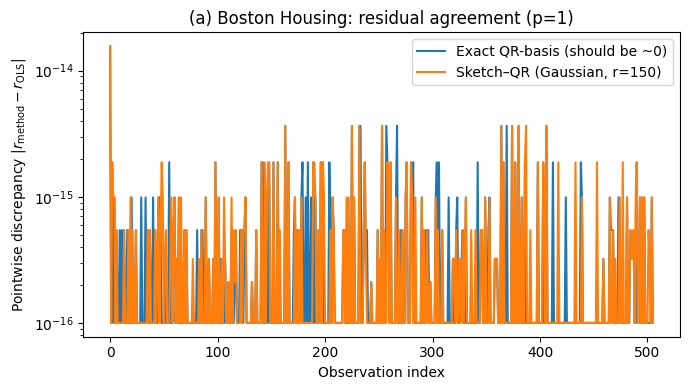


[(b) Boston Housing: residual agreement (p=4)] n=506, p=4
  ||r_exact - r_ols||/||r_ols|| = 6.361e-16
  ||r_sk    - r_ols||/||r_ols|| = 6.584e-16


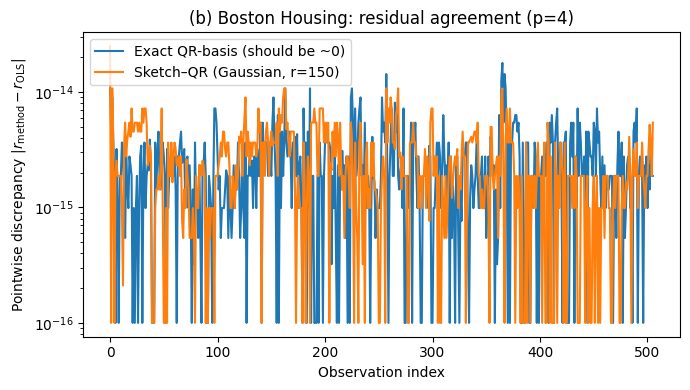


Saved: fig4a_residual_diff_single.pdf, fig4b_residual_diff_multi.pdf


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from numpy.linalg import norm
from sklearn.preprocessing import StandardScaler

# -----------------------------
# Settings (match manuscript)
# -----------------------------
ASSIGN_DIR = "/kaggle/input/assignment-1"
HOUSE_PATH = str(Path(ASSIGN_DIR) / "DS for Predicting House Prices- Prblm 1.csv")

SKETCH_TYPE = "Gaussian"   # "Gaussian" or "CountSketch"
R_SKETCH = 150             # sketch size r
SEED = 123
EPS_PLOT = 1e-16           # avoid log(0) if you use semilogy

# -----------------------------
# Helpers
# -----------------------------
def _clean_cols(df):
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]
    return df

def _find_col(df, name):
    """Case-insensitive exact column match."""
    name = name.lower().strip()
    for c in df.columns:
        if str(c).lower().strip() == name:
            return c
    return None

def robust_rank_full(X, tol=None):
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    if s.size == 0:
        return 0, U, s, Vt
    if tol is None:
        tol = max(X.shape) * np.finfo(float).eps * s[0]
    r = int(np.sum(s > tol))
    return r, U, s, Vt

def colspace_basis_svd(X):
    r, U, s, Vt = robust_rank_full(X)
    return U[:, :r], r

def proj_res_from_Q(Q, y):
    return y - Q @ (Q.T @ y)

def standardize_center(X, y):
    sc = StandardScaler()
    Xs = sc.fit_transform(X)
    yc = y - float(np.mean(y))
    return Xs, yc

def ols_residual_lstsq(Xs, y):
    beta, *_ = np.linalg.lstsq(Xs, y, rcond=None)
    return y - Xs @ beta

# -----------------------------
# Sketch–QR (pinv lift)
# -----------------------------
def gaussian_sketch(n, r, rng):
    return rng.standard_normal((r, n)) / np.sqrt(r)

def countsketch(n, r, rng):
    h = rng.integers(0, r, size=n)
    s = rng.choice([-1, 1], size=n)
    S = np.zeros((r, n))
    S[h, np.arange(n)] = s
    return S

def sketch_qr_basis(X, r=150, sketch="Gaussian", seed=123):
    rng = np.random.default_rng(seed)
    n, p = X.shape

    if sketch.lower() in ["gaussian", "normal"]:
        S = gaussian_sketch(n, r, rng)
    elif sketch.lower() in ["countsketch", "count"]:
        S = countsketch(n, r, rng)
    else:
        raise ValueError("sketch must be 'Gaussian' or 'CountSketch'")

    Xtil = S @ X
    _, Rm = np.linalg.qr(Xtil, mode="reduced")

    # critical: pseudoinverse
    Z = X @ np.linalg.pinv(Rm)
    Qtilde, _ = np.linalg.qr(Z, mode="reduced")

    # keep effective rank of Xtil
    rtil, _, _, _ = robust_rank_full(Xtil)
    rtil = max(1, rtil)
    return Qtilde[:, :rtil]

def sketch_qr_residual(X, y, r=150, sketch="Gaussian", seed=123):
    Q = sketch_qr_basis(X, r=r, sketch=sketch, seed=seed)
    return proj_res_from_Q(Q, y)

# -----------------------------
# Load Boston-like models for Fig 4
# -----------------------------
def load_boston_fig4_models(house_path=HOUSE_PATH):
    df = _clean_cols(pd.read_csv(house_path))

    # Optional renames if your CSV uses classic Boston aliases
    if _find_col(df, "Price") is None and _find_col(df, "medv") is not None:
        df = df.rename(columns={_find_col(df, "medv"): "Price"})
    if _find_col(df, "Area") is None and _find_col(df, "rm") is not None:
        df = df.rename(columns={_find_col(df, "rm"): "Area"})

    ycol = _find_col(df, "Price")
    x1   = _find_col(df, "Area")
    tax  = _find_col(df, "tax")
    ptr  = _find_col(df, "ptratio")
    lst  = _find_col(df, "lstat")

    missing = [nm for nm, col in
               [("Price", ycol), ("Area", x1), ("tax", tax), ("ptratio", ptr), ("lstat", lst)]
               if col is None]
    if missing:
        raise ValueError(
            f"Fig 4 needs columns {missing}. Available columns: {list(df.columns)}"
        )

    use_cols = [ycol, x1, tax, ptr, lst]
    tmp = df[use_cols].replace("?", np.nan).apply(pd.to_numeric, errors="coerce").dropna()

    y  = tmp[ycol].to_numpy(float)
    X1 = tmp[[x1]].to_numpy(float)
    X4 = tmp[[x1, tax, ptr, lst]].to_numpy(float)

    return (X1, X4, y)

# -----------------------------
# Make Figure 4 (difference curves)
# -----------------------------
def plot_residual_diff_panel(X, y, title, out_pdf, out_png=None):
    # standardize predictors + center response (match manuscript)
    Xs, yc = standardize_center(X, y)

    # OLS residual
    r_ols = ols_residual_lstsq(Xs, yc)

    # Exact geometric residual (QR/SVD basis)
    Q_exact, _ = colspace_basis_svd(Xs)
    r_exact = proj_res_from_Q(Q_exact, yc)

    # Sketch–QR residual
    r_sk = sketch_qr_residual(Xs, yc, r=R_SKETCH, sketch=SKETCH_TYPE, seed=SEED)

    # Difference curves (Option 2)
    d_exact = r_exact - r_ols
    d_sk    = r_sk    - r_ols

    # Print summary numbers for manuscript notes (optional)
    rel_exact = norm(d_exact) / max(norm(r_ols), 1e-12)
    rel_sk    = norm(d_sk)    / max(norm(r_ols), 1e-12)
    print(f"\n[{title}] n={Xs.shape[0]}, p={Xs.shape[1]}")
    print(f"  ||r_exact - r_ols||/||r_ols|| = {rel_exact:.3e}")
    print(f"  ||r_sk    - r_ols||/||r_ols|| = {rel_sk:.3e}")

    # Plot absolute pointwise discrepancies
    idx = np.arange(len(yc))

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.semilogy(idx, np.abs(d_exact) + EPS_PLOT, label="Exact QR-basis (should be ~0)")
    ax.semilogy(idx, np.abs(d_sk)    + EPS_PLOT, label=f"Sketch–QR ({SKETCH_TYPE}, r={R_SKETCH})")
    ax.set_xlabel("Observation index")
    ax.set_ylabel(r"Pointwise discrepancy $|r_{\mathrm{method}}-r_{\mathrm{OLS}}|$")
    ax.set_title(title)
    ax.legend()
    fig.tight_layout()
    fig.savefig(out_pdf, dpi=300)
    if out_png is not None:
        fig.savefig(out_png, dpi=300)
    plt.show()

# Run and save both panels
X1, X4, y = load_boston_fig4_models(HOUSE_PATH)

plot_residual_diff_panel(
    X1, y,
    title="(a) Boston Housing: residual agreement (p=1)",
    out_pdf="fig4a_residual_diff_single.pdf",
    out_png="fig4a_residual_diff_single.png"
)

plot_residual_diff_panel(
    X4, y,
    title="(b) Boston Housing: residual agreement (p=4)",
    out_pdf="fig4b_residual_diff_multi.pdf",
    out_png="fig4b_residual_diff_multi.png"
)

print("\nSaved: fig4a_residual_diff_single.pdf, fig4b_residual_diff_multi.pdf")
